<a href="https://colab.research.google.com/github/iabhibagaria/Abhi/blob/master/credit_card_fraud_detection_model.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

The goal of this notebook is to predict the fraud transactions with high accuracy.



In [1]:
import numpy as np
import pandas as pd

import seaborn as sns
import matplotlib.pyplot as plt

In [2]:
# reading the file
df = pd.read_csv('/content/drive/MyDrive/Ml dl data science  datasets/creditcard.csv')

In [3]:
df.head()

,Time,V1,V2,V3,V4,V5,V6,V7,V8,V9,V10,V11,V12,V13,V14,V15,V16,V17,V18,V19,V20,V21,V22,V23,V24,V25,V26,V27,V28,Amount,Class
0,0.0,-1.359807,-0.072781,2.536347,1.378155,-0.338321,0.462388,0.239599,0.098698,0.363787,0.090794,-0.551600,-0.617801,-0.991390,-0.311169,1.468177,-0.470401,0.207971,0.025791,0.403993,0.251412,-0.018307,0.277838,-0.110474,0.066928,0.128539,-0.189115,0.133558,-0.021053,149.62,0
1,0.0,1.191857,0.266151,0.166480,0.448154,0.060018,-0.082361,-0.078803,0.085102,-0.255425,-0.166974,1.612727,1.065235,0.489095,-0.143772,0.635558,0.463917,-0.114805,-0.183361,-0.145783,-0.069083,-0.225775,-0.638672,0.101288,-0.339846,0.167170,0.125895,-0.008983,0.014724,2.69,0
2,1.0,-1.358354,-1.340163,1.773209,0.379780,-0.503198,1.800499,0.791461,0.247676,-1.514654,0.207643,0.624501,0.066084,0.717293,-0.165946,2.345865,-2.890083,1.109969,-0.121359,-2.261857,0.524980,0.247998,0.771679,0.909412,-0.689281,-0.327642,-0.139097,-0.055353,-0.059752,378.66,0
3,1.0,-0.966272,-0.185226,1.792993,-0.863291,-0.010309,1.247203,0.237609,0.377436,-1.387024,-0.054952,-0.226487,0.178228,0.507757,-0.287924,-0.631418,-1.059647,-0.684093,1.965775,-1.232622,-0.208038,-0.108300,0.005274,-0.190321,-1.175575,0.647376,-0.221929,0.062723,0.061458,123.50,0
4,2.0,-1.158233,0.877737,1.548718,0.403034,-0.407193,0.095921,0.592941,-0.270533,0.817739,0.753074,-0.822843,0.538196,1.345852,-1.119670,0.175121,-0.451449,-0.237033,-0.038195,0.803487,0.408542,-0.009431,0.798278,-0.137458,0.141267,-0.206010,0.502292,0.219422,0.215153,69.99,0


So here: 0 = fair transaction, and 1 = fraud transaction.

And also, the Time column is not of much use. So will discard it

In [4]:
df = df.drop(['Time'], axis = 1)

In [5]:
#checking null values if they exist.
df.isnull().sum().sum()

0

No null values

**Data exploration**

The data contains PCA transformed features, so the columns are meaningless except the Amount and Class. I will only perform the EDA which is necessary for building model.

Text(0, 0.5, 'Amount of Transaction')

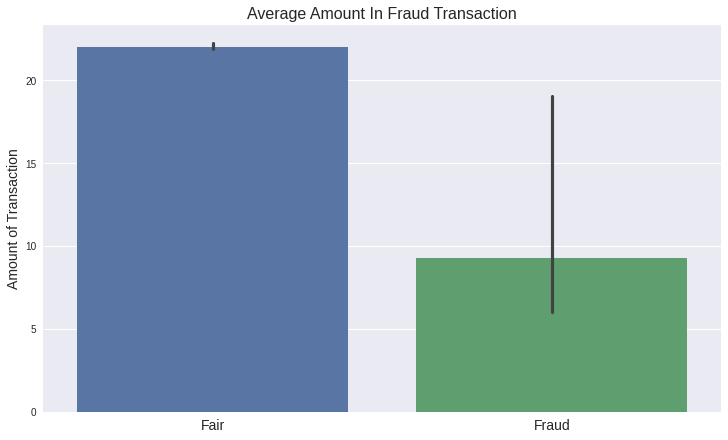

In [6]:
# Lets have a look at the transaction values in both cases

plt.style.use('seaborn')
fig, ax = plt.subplots(1,1, figsize= (10,6), constrained_layout = True)

# will use median rather than mean so no outliers is there, gives a clear picture
ax = sns.barplot(x='Class', y= 'Amount', data=df, estimator= np.median, ax=ax)

plt.title("Average Amount In Fraud Transaction", size = 16)

ax.set_xticklabels(['Fair', 'Fraud'], fontsize = 14)
plt.xlabel(None)
plt.ylabel('Amount of Transaction', fontsize = 14)


On an average, the amount in fraud transactions is lower than fair transactions. The reason I think can be, the fraud's are smart, they know if they do a fraud of big amount they may get caught, so they do multiple frauds of smaller amount.

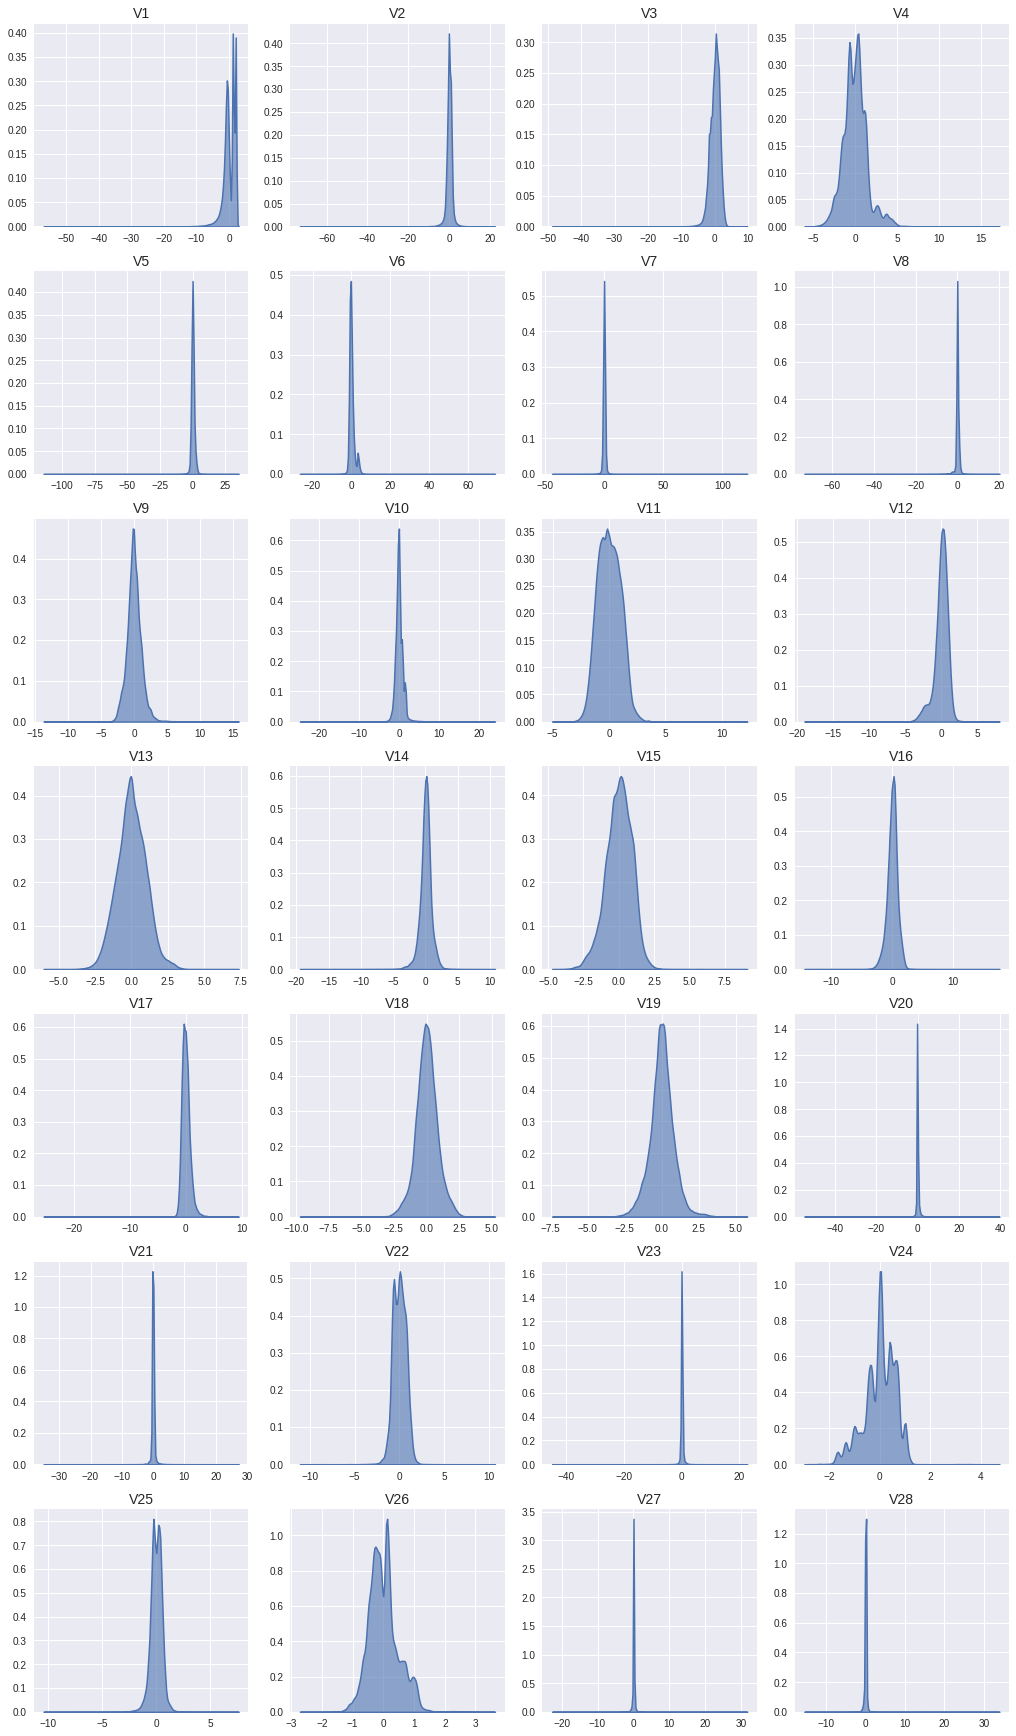

In [7]:
# Now EDA for v1,v2,.....v28

v_features = df.iloc[:,:-2].columns.to_list()

plt.style.use('seaborn')
fig, ax = plt.subplots(7,4, figsize = (14, 24), constrained_layout = True)

for col, axis in zip(v_features, ax.ravel()):  # ax.ravel() kind of flattens the 2d to 1d for iteration
    axis = sns.kdeplot(x = col, data = df, fill = True, alpha = 0.6, linewidth = 1.5, ax=axis)
    axis.set_title(col, fontsize = 14)
    axis.set_xlabel(None)
    axis.set_ylabel(None)

 

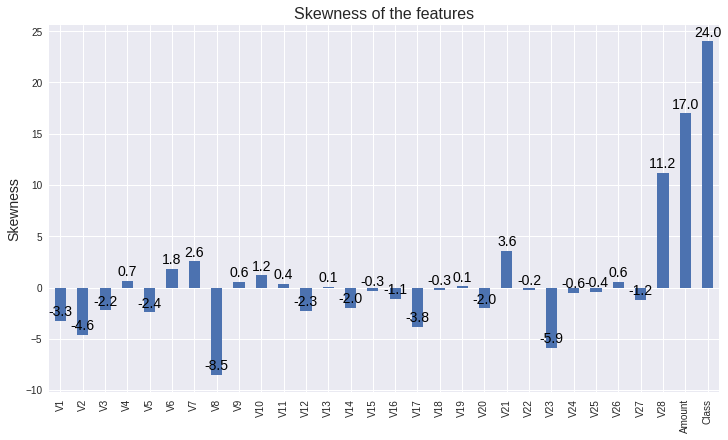

In [8]:
# Checking the skewness values
plt.style.use('seaborn')
fig, ax = plt.subplots(1,1, figsize = (10, 6), constrained_layout = True)
ax = df.skew(axis = 0).plot(kind = 'bar')

for i in ax.patches:
    ax.text(x = i.get_x() + i.get_width()/2, y = i.get_height()+0.5, 
            s = f"{np.round(i.get_height(), 1)}", 
            ha = 'center', size = 14, rotation = 0, color = 'black')
    
ax.set_ylabel('Skewness', fontsize = 14)
ax.set_title('Skewness of the features', fontsize = 16);


Many features have normal distribution. Each of the PCs given by PCA is a linear combination of the original features and the original features were normally distributed , so every linear combination of them i.e. PCs are also normally distributed.

There are also some features which are skew distributed, so I will use quantile transform for this purprose. I will be considering (-0.5,0.5) range for skewness, any feature having value beyound this range will get transformed.

❕ I have tried log transform by adding some constant to negetive values and also inverse hyperbolic tangent transform by scaling features in (-1, 1) range, but none of them reduced the skewness, so I am using quantile transform.



In [9]:
from sklearn.preprocessing import quantile_transform

v_feature = df.iloc[:,: -2].columns
df[v_feature] = pd.DataFrame(quantile_transform(df[v_feature], n_quantiles = 500), columns= v_feature)

print('Skewness after Quantile Transform')
df[v_features].skew(axis = 0)

/usr/local/lib/python3.7/dist-packages/sklearn/preprocessing/_data.py:2670: FutureWarning: The default value of `copy` will change from False to True in 0.23 in order to make it more consistent with the default `copy` values of other functions in :mod:`sklearn.preprocessing` and prevent unexpected side effects by modifying the value of `X` inplace. To avoid inplace modifications of `X`, it is recommended to explicitly set `copy=True`
  FutureWarning)


Skewness after Quantile Transform


V1    -0.003170
V2    -0.002643
V3    -0.002848
V4     0.001961
V5    -0.000841
V6     0.007430
V7    -0.003481
V8    -0.004624
V9     0.003127
V10    0.000766
V11    0.001266
V12    0.000478
V13    0.000016
V14    0.003302
V15    0.002970
V16    0.005133
V17   -0.000527
V18    0.003082
V19   -0.005518
V20    0.000311
V21   -0.005706
V22    0.004009
V23    0.000221
V24    0.004943
V25   -0.000295
V26    0.000708
V27   -0.003519
V28   -0.000544
dtype: float64

So now skewness is close to Zero.
Now will check about class imbalance.

Imbalanced classifications pose a challenge for predictive modeling as most of the machine learning algorithms used for classification were designed around the assumption of an equal number of examples for each class. This results in models that have poor predictive performance, specifically for the minority class.



Text(0, 0.5, 'Number of Transactions')

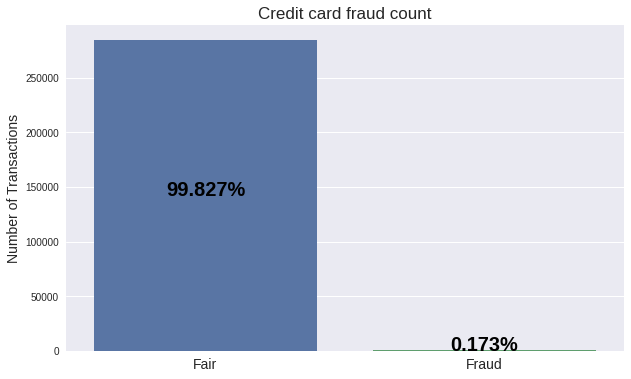

In [10]:
#checking for class imbalance

plt.style.use('seaborn')
fig = plt.figure(figsize=(10,6))

ax = sns.countplot(x= "Class", data= df)

for i in ax.patches:
  ax.text(x = i.get_x() + i.get_width()/2, y = i.get_height()/2, 
            s = f"{np.round(i.get_height()/len(df)*100, 3)}%", 
            ha = 'center', size = 20, weight = 'bold', rotation = 0, color = 'black')
plt.title("Credit card fraud count", size = 17)
ax.set_xticklabels(['Fair', 'Fraud'], fontsize = 14)

plt.xlabel(None)
plt.ylabel('Number of Transactions', fontsize = 14)

Only 0.173% tractions are fraud, which is very much less than other class. If we train our model on this unbalanced class data, then the model won't learn much from Fraud class and will try to give more importance to Fair class, which we don't want. Let's see that in action, I will train a simple logistic regression model and see its performance.

So 1st we will model on unbalanced data and then on balanced data, will compare them.

In [11]:
#splitting data in test train datasets
from sklearn.model_selection import train_test_split

X = df.drop(['Class'], axis=1)
y = df['Class']

X_train, X_test , y_train, y_test = train_test_split(X,y, train_size= 0.7, stratify = df['Class'], random_state = 99)

In [12]:
#training data on imbalanced model
from sklearn.linear_model import LogisticRegression
from sklearn import metrics

model1 = LogisticRegression(solver ='liblinear').fit(X_train, y_train)
matrix1 = metrics.confusion_matrix(y_test, model1.predict(X_test))

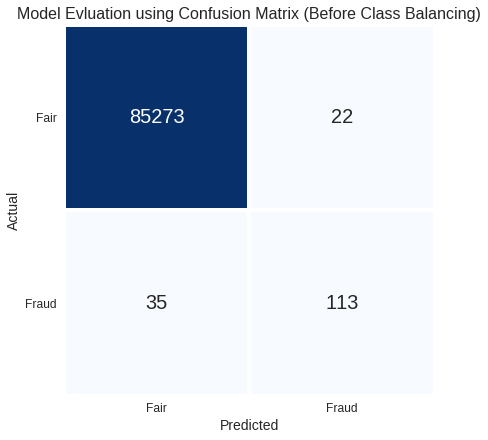

In [13]:
plt.style.use('seaborn')
fig, axis = plt.subplots(1,1, figsize=(10, 6), constrained_layout = True)
axis = sns.heatmap(matrix1, annot=True, fmt = '.0f', cbar=False, cmap='Blues',
                        linewidths=3, square=True, ax = axis, annot_kws={"fontsize":20})

axis.set_xlabel('Predicted', fontsize=14)
axis.set_ylabel('Actual', fontsize=14)
axis.set_xticklabels(['Fair','Fraud'], fontsize=12)
axis.set_yticklabels(['Fair','Fraud'], fontsize=12, rotation=0);
plt.title('Model Evluation using Confusion Matrix (Before Class Balancing)', fontsize = 16);


There are 35 False Negetives out of 148. It means that, out of 148 frauds, our model couldn't identify 35 (24%), this is mainly due to class imbalance. We don't want to let the fraud escape this easily, so let's balance the classes.



I am using SMOTE and ADASYN methods. They both are oversampling methods, i.e. they create synthetic data for manority class so that it becomes similar in count with majority class.


SMOTE (Synthetic Minority Over-sampling Technique) creates the synthetic data for minority class, using linear method. It takes two close minority points and creates a new point on a line joining the two points.

ADASYN (Adaptive Synthetic) uses a weighted distribution for different minority class examples according to their level of difficulty in learning, where more synthetic data is generated for minority class examples that are harder to learn compared to those minority examples that are easier to learn. It creates the synthetic data near to the minority points having less density.

from imblearn.over_sampling import SMOTE, ADASYN

In [19]:
from imblearn.over_sampling import SMOTE, ADASYN
from sklearn.preprocessing import StandardScaler
from sklearn.pipeline import Pipeline

X_train_new, y_train_new = SMOTE().fit_resample(X_train, y_train)

print('Before resmapling : ', y_train.value_counts())
print('After resmapling : ', y_train_new.sum())

pipeline = Pipeline([('model', LogisticRegression(solver='liblinear'))])
pipeline.fit(X_train_new, y_train_new)

/usr/local/lib/python3.7/dist-packages/sklearn/utils/deprecation.py:87: FutureWarning: Function safe_indexing is deprecated; safe_indexing is deprecated in version 0.22 and will be removed in version 0.24.
  warnings.warn(msg, category=FutureWarning)


Before resmapling :  0    199020
1       344
Name: Class, dtype: int64
After resmapling :  199020


Pipeline(memory=None,
         steps=[('model',
                 LogisticRegression(C=1.0, class_weight=None, dual=False,
                                    fit_intercept=True, intercept_scaling=1,
                                    l1_ratio=None, max_iter=100,
                                    multi_class='auto', n_jobs=None,
                                    penalty='l2', random_state=None,
                                    solver='liblinear', tol=0.0001, verbose=0,
                                    warm_start=False))],
         verbose=False)

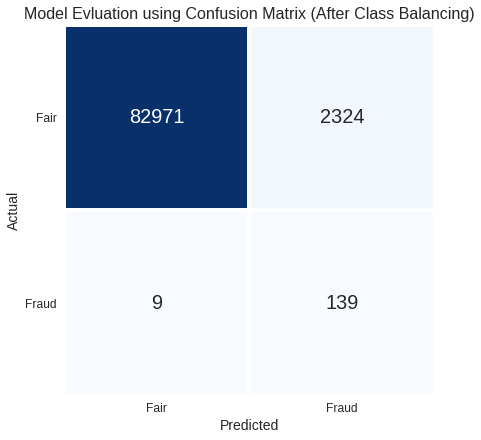

In [20]:
matrix_new = metrics.confusion_matrix(y_test, pipeline.predict(X_test))
plt.style.use('seaborn')
fig, axis = plt.subplots(1,1, figsize=(10, 6), constrained_layout = True)
axis = sns.heatmap(matrix_new, annot=True, fmt = '.0f', cbar=False, cmap='Blues',
                        linewidths=3, square=True, ax = axis, annot_kws={"fontsize":20})

axis.set_xlabel('Predicted', fontsize=14)
axis.set_ylabel('Actual', fontsize=14)
axis.set_xticklabels(['Fair','Fraud'], fontsize=12)
axis.set_yticklabels(['Fair','Fraud'], fontsize=12, rotation=0);
plt.title('Model Evluation using Confusion Matrix (After Class Balancing)', fontsize = 16);


There are only 9 False Negetives out of 148. It means that, out of 148 frauds, our model couldn't identify only 9 (6%) frauds. Previously, before class balancing, False Negetives were 35 (24%) and now they are 9, 4 times reduction!

Let's try with ADASYN.

In [22]:
# Oversampling minority class using ADASYN
X_train_ada, y_train_ada = ADASYN().fit_resample(X_train, y_train)

print('Before resmapling : ', y_train.value_counts())
print('After resmapling : ', y_train_ada.sum())

pipeline = Pipeline([('model', LogisticRegression(solver='liblinear'))])
pipeline.fit(X_train_ada, y_train_ada)

/usr/local/lib/python3.7/dist-packages/sklearn/utils/deprecation.py:87: FutureWarning: Function safe_indexing is deprecated; safe_indexing is deprecated in version 0.22 and will be removed in version 0.24.
  warnings.warn(msg, category=FutureWarning)


Before resmapling :  0    199020
1       344
Name: Class, dtype: int64
After resmapling :  199009


Pipeline(memory=None,
         steps=[('model',
                 LogisticRegression(C=1.0, class_weight=None, dual=False,
                                    fit_intercept=True, intercept_scaling=1,
                                    l1_ratio=None, max_iter=100,
                                    multi_class='auto', n_jobs=None,
                                    penalty='l2', random_state=None,
                                    solver='liblinear', tol=0.0001, verbose=0,
                                    warm_start=False))],
         verbose=False)

The recall is slightly improved but on the expense of precision.

focusing on recall as, it a good measure of false negetives. If a fair transaction is predicted as fraud, then manual step can mitigate this problem but if fraud is predicted as fair, then it can cause loss to the customer as well as bank.

But if only recall the prime importance then the threshold will be set at 0 so that we get recall as 100% but very high false positives, so I am giving 50% weightage to accuracy and 50% to recall.

Now will do modelling.

1. **Logistic regression**

In [25]:
from sklearn.linear_model import LogisticRegressionCV
pipeline = Pipeline([('model', LogisticRegressionCV(solver='liblinear', cv = 5))])
pipeline.fit(X_train_ada, y_train_ada)

Pipeline(memory=None,
         steps=[('model',
                 LogisticRegressionCV(Cs=10, class_weight=None, cv=5,
                                      dual=False, fit_intercept=True,
                                      intercept_scaling=1.0, l1_ratios=None,
                                      max_iter=100, multi_class='auto',
                                      n_jobs=None, penalty='l2',
                                      random_state=None, refit=True,
                                      scoring=None, solver='liblinear',
                                      tol=0.0001, verbose=0))],
         verbose=False)

I will be using AUC ROC curve for model evaluation as it is independent of the threshold. Sklearn considers 0.5 as threshold for calculating Accuracy, Precision, Recall, etc. but the value of threshold varies with models, and so I will be using AUC ROC curve to find out the best threshold and use that to predict.



In [26]:
# Plotting the ROC Curve and finding optimal threshold
# Function for plotting ROC curve, confurion matrix and finding optimal threshold
def my_roc_curve(model, accuracy_weight, title, X_train, y_train):
    from sklearn import metrics
    # Plotting AUC ROC curve
    y_scores = model.predict(X_train)
    fpr, tpr, thresholds = metrics.roc_curve(y_train, y_scores)
    
    fig, (ax1,ax2) = plt.subplots(1,2, figsize = (12, 6), constrained_layout = True)
    ax1.plot(fpr, tpr, color='skyblue', label='ROC')
    ax1.plot([0, 1], [0, 1], color='pink', linestyle='--')
    ax1.text(x = 0.8, y = 0.3,
            s = f"AUC : {round(metrics.roc_auc_score(y_train, y_scores),2)}",
            ha = 'center', size = 12, rotation = 0, color = 'black',
            bbox=dict(boxstyle="round,pad=0.5", fc='skyblue', ec="skyblue", lw=2));

    ax1.set_xlabel('False Positive Rate', fontsize = 12)
    ax1.set_ylabel('True Positive Rate', fontsize = 12)
    ax1.set_title(f'ROC curve',  fontsize=16, y=1.05)

    # Plotting optimal Confusion Matrix
    from sklearn import metrics
    probability = model.predict_proba(X_train)
    matrix = pd.DataFrame()
    
    base_accuracy = metrics.accuracy_score(y_train, model.predict(X_train))
    base_recall = metrics.recall_score(y_train, model.predict(X_train))
    best_score = 0.6*base_accuracy + 0.4*base_recall
    best_thresold = 0.5
    
    # Finding optimul thresold to maximize > accuracy_weight*threshold_accuracy + (1-accuracy_weight)*threshold_recall
    for threshold in np.linspace(0, 1, 100):
        y_predict = (probability>=threshold).astype(int)[:,1]
        threshold_accuracy = metrics.accuracy_score(y_train, y_predict)
        threshold_recall = metrics.recall_score(y_train, y_predict)
        weighted_score = accuracy_weight*threshold_accuracy + (1-accuracy_weight)*threshold_recall
        
        if weighted_score>best_score:
            best_thresold = threshold
            best_score = weighted_score
    
    y_predict = (probability>=best_thresold).astype(int)[:,1]
    matrix = metrics.confusion_matrix(y_train, y_predict)

    ax2 = sns.heatmap(matrix, annot=True, fmt = '.0f', cbar=False, cmap='Blues',
                        linewidths=3, square=True, ax = ax2, annot_kws={"fontsize":20})
    ax2.set_title(f"Confusion Matrics | Threshold : {round(best_thresold, 2)}", fontsize=16, y=1.05);
    ax2.set_xlabel('Predicted', fontsize=12)
    ax2.set_ylabel('Actual', fontsize=12)
    ax2.set_xticklabels([0,1], fontsize=12 )
    ax2.set_yticklabels([0,1], fontsize=12, rotation=0)
    
    print('Optimal Threshold for Accuracy and Recall is : ', round(best_thresold, 2))
    print(f"Train Accuracy for  {title}: ", round(metrics.accuracy_score(y_train, y_predict),2), 
          f"| Train Recall for {title}: ", round(metrics.recall_score(y_train, y_predict),2))
    
    plt.suptitle(f'{title}', fontsize=19, y=1.05)
    
    # For test data
    probability = model.predict_proba(X_test)
    y_predict = (probability>=best_thresold).astype(int)[:,1]
    print(f"Test Accuracy for {title}: ", round(metrics.accuracy_score(y_test, y_predict),2),
         f"| Test Recall for {title}: ", round(metrics.recall_score(y_test, y_predict),2))


Optimal Threshold for Accuracy and Recall is :  0.25
Train Accuracy for  Logistic Regression:  0.93 | Train Recall for Logistic Regression:  0.96
Test Accuracy for Logistic Regression:  0.9 | Test Recall for Logistic Regression:  0.95


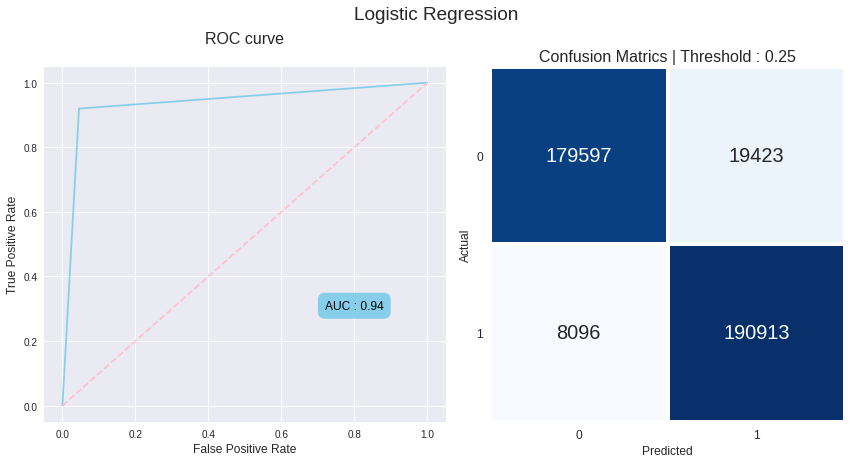

In [27]:
my_roc_curve(pipeline, 0.5, 'Logistic Regression', X_train_ada, y_train_ada)

 2. **Cat Boost**

In [47]:
from catboost import CatBoostClassifier

cat_model = CatBoostClassifier(task_type = 'CPU', od_type = 'Iter')


In [48]:
# Creating evaluation set for catboost
X_train_cat, X_eval, y_train_cat, y_eval = train_test_split(X_train_ada, y_train_ada, stratify = y_train_ada,random_state = 99)


In [49]:
cat_model.fit(X_train_cat, y_train_cat, use_best_model = True, eval_set = (X_eval, y_eval), verbose = 100, early_stopping_rounds = 50)


Custom logger is already specified. Specify more than one logger at same time is not thread safe.

Learning rate set to 0.129488
0:	learn: 0.5073535	test: 0.5071652	best: 0.5071652 (0)	total: 213ms	remaining: 3m 32s
100:	learn: 0.0097830	test: 0.0100705	best: 0.0100705 (100)	total: 12.8s	remaining: 1m 53s
200:	learn: 0.0029214	test: 0.0033388	best: 0.0033388 (200)	total: 25s	remaining: 1m 39s
300:	learn: 0.0028241	test: 0.0032310	best: 0.0032310 (299)	total: 34.8s	remaining: 1m 20s
400:	learn: 0.0026750	test: 0.0030811	best: 0.0030811 (400)	total: 44.9s	remaining: 1m 7s
500:	learn: 0.0025810	test: 0.0029864	best: 0.0029864 (498)	total: 54.8s	remaining: 54.6s
600:	learn: 0.0022838	test: 0.0027029	best: 0.0027029 (600)	total: 1m 5s	remaining: 43.3s
700:	learn: 0.0022715	test: 0.0026900	best: 0.0026900 (699)	total: 1m 15s	remaining: 32.2s
800:	learn: 0.0022588	test: 0.0026777	best: 0.0026777 (800)	total: 1m 25s	remaining: 21.3s
900:	learn: 0.0022178	test: 0.0026328	best: 0.0026328 (886)	total: 1m 35s	remaining: 10.5s
Stopped by overfitting detector  (50 iterations wait)

bestTest = 0.0

Optimal Threshold for Accuracy and Recall is :  0.76
Train Accuracy for  CatBoost:  1.0 | Train Recall for CatBoost:  1.0
Test Accuracy for CatBoost:  1.0 | Test Recall for CatBoost:  0.84


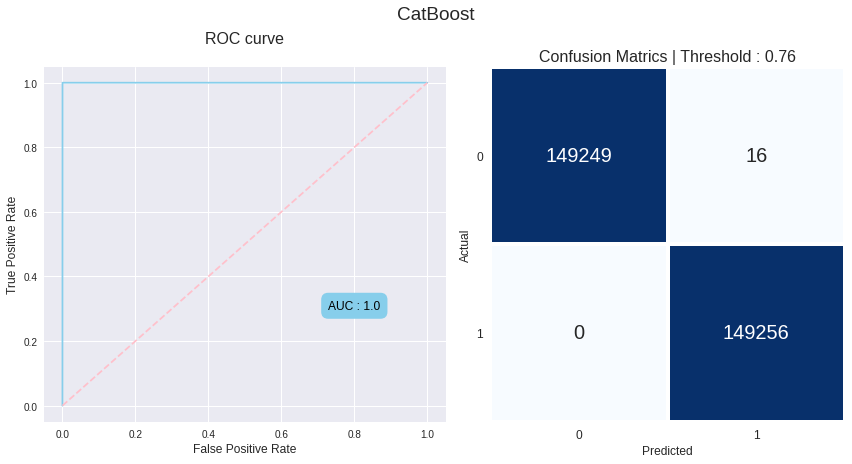

In [50]:
my_roc_curve(cat_model, 0.5, 'CatBoost', X_train_cat, y_train_cat)


In [51]:
probability = cat_model.predict_proba(X_test)
y_predict = (probability>=0.7).astype(int)[:,1]
matrix = metrics.confusion_matrix(y_test, y_predict)
matrix


array([[85264,    31],
       [   23,   125]])

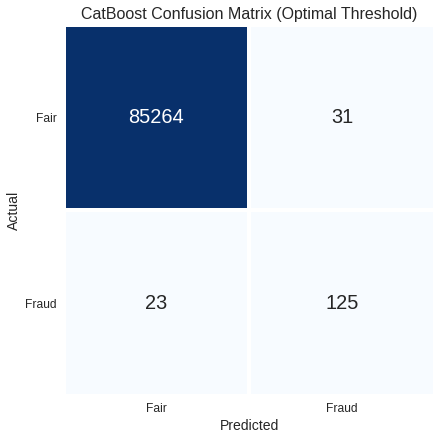

In [52]:
plt.style.use('seaborn')
fig, axis = plt.subplots(1,1, figsize=(10, 6), constrained_layout = True)
axis = sns.heatmap(matrix, annot=True, fmt = '.0f', cbar=False, cmap='Blues',
                        linewidths=3, square=True, ax = axis, annot_kws={"fontsize":20})

axis.set_xlabel('Predicted', fontsize=14)
axis.set_ylabel('Actual', fontsize=14)
axis.set_xticklabels(['Fair','Fraud'], fontsize=12)
axis.set_yticklabels(['Fair','Fraud'], fontsize=12, rotation=0);
plt.title('CatBoost Confusion Matrix (Optimal Threshold)', fontsize = 16);

That looks good! We got a recall of 84% and 97% accuracy!

